# Perceptrons and Logistic regression
Last time, we saw a bunch of (fairly complicated) probabilistic classifiers, all of which used Bayes Theorems + certain assumptions to classify data by estimating posterior probabilities. This class, we'll see a different approach to classification, which is based on the idea of learning a decision boundary that separates the classes. 

### Setup
As usual, we are given a labelled dataset with the following form:
- There are $m$ instances in the dataset. 
- There are $n$ features $X_i$, each corresponding to a column vector $\mathbf{x}_i \in \mathbb{R}^m$. 
- There is a single binary target $Y$ which takes the value $0$ or $1$ for each instance. The target is represented by a column vector $\mathbf{y} \in \{0,1\}^m$.

In this notebook, we restrict ourselves to the case of binary classification for simplicity, and we will generalize (logistic regression) to the multi-class case later, when we get a deeper look at information theory.

## Perceptrons
These are (perhaps) the simplest binary classifiers, and they also happen to be the building blocks of neural networks. 

### Biological inspiration
Consider how the brain works:
- The brain is made up of billions of cells called **neurons**.
- Neurons are connected to each other through **synapses**.
- Each neuron receives signals from other neurons through these synapses.
- Each connection has a different strength (or “weight”), which determines how much influence one neuron (the input) has over another (the output).
- When a neuron receives enough input from other neurons, it “fires” or "activates" and sends a signal to other neurons.
- The "enough input" is determined by a threshold specific to the neuron, which is a fixed value that the input must exceed in order for the neuron to fire.

### McCulloch-Pitts model
The starting point for creating a mathematical abstraction of this process is to view the neurons task as one of *binary classification*: the neuron receives a collection of inputs, and it has to decide whether to fire or not.

Warren McCulloch and Walter Pitts were the first to propose a mathematical model of a neuron in 1943 (as such, they are credited with being the inventors of the concept of an artificial neural network). They were both trained in mathematics and logic, and they were interested in the question of how the brain could perform logical operations. They proposed a model of a neuron that was based on the idea of a binary threshold unit, which is a simple mathematical function that takes a collection of inputs and produces a binary output (either 0 or 1). Each neuron was in a state of $0$ (inactive) or $1$ (active), and the neuron would change its state based on the inputs it received. 

In their model, the neurons were arranged into layers, with each layer corresponding to a time-step in the processing of information. Thus, a neuron at time $t$ would receive inputs from neurons at time $t-1$, and it would produce an output that would be sent to neurons at time $t+1$, and so on. This modelled the flow of information as a directed graph, and they proved (in some precise sense) that if the graph was acyclic, then the network of neurons could perform any logical operation. I refer you to the wikipedia article and associated links for more information: https://en.wikipedia.org/wiki/Neural_network#McCulloch%E2%80%93Pitts_neuron

### Rosenblatt's perceptron
In 1958, at the Cornell Aeronautical Laboratory, Frank Rosenblatt implemented (or simulated) a working model of the McCulloch-Pitts neuron, which he called the **perceptron**. He was a psychologist and computer scientist, and he was interested in the question of how the brain could learn from experience. He proposed a model of a perceptron that was based on the idea of a learning algorithm, which is a set of rules that can be used to update the weights of the connections between neurons in order to improve the performance of the network. This process is now recognized as a simplified/discretized form of **gradient descent**. 

Check out the wikipedia article for more information, and some pictures of a room-sized perceptron: https://en.wikipedia.org/wiki/Perceptron

### Formal definition of a perceptron
In the language of modern ML, a perceptron is a **binary classifier** that is built as follows:
- Each neuron receives a collection of inputs $\mathbf{x} = (x_1, \ldots, x_n) \in \mathbb{R}^n$ (the signals).
- Each input has a weight $w_i \in \mathbb{R}$ (the strength of the connection).
- The neuron computes a weighted sum of the inputs: $z = \sum_{i=1}^n w_i x_i$.
- The neuron has it's own threshold $t \in \mathbb{R}$ (the neuron-specific threshold).
- The neuron fires if $z \geq t$, and does not fire otherwise.
- Thus, the output of a neuron can be expressed as binary output: $y = 1$ if $z \geq t$, and $y = 0$ otherwise.

Observe that if we set $b = -t$, then the above process can be summarized as a function $P_{\mathbf{w},b}: \mathbb{R}^n \to \{0,1\}$ that is a composition:
\begin{equation*}
    \mathbb{R}^n \xrightarrow{F_{\mathbf{w},b}} \mathbb{R} \xrightarrow{H} \{0,1\},
\end{equation*}
in which the first function $F_{\mathbf{w},b}$ is linear, and the second function $H$ is the **Heaviside step function** defined by
\begin{align*}
    H(z) = \begin{cases}
        1 & \textup{if } z \geq 0,\\
        0 & \textup{if } z < 0.
    \end{cases}
\end{align*}
Thus, the function $P_{\mathbf{w},b}$ can be written directly as
\begin{equation*}
    P_{\mathbf{w},b}(\mathbf{x}) = H(F_{\mathbf{w},b}(\mathbf{x})) = \begin{cases}
        1 & \textup{if } \mathbf{w}^T\mathbf{x} + b \geq 0,\\
        0 & \textup{if } \mathbf{w}^T\mathbf{x} + b < 0.
    \end{cases}
\end{equation*}

### Hyperplanes
The formula for the perceptron can be understood in geometric terms. To understand this, let's recall some concepts from linear algebra. 
- A **subspace** of $\mathbb{R}^n$ is a collection of vectors that is closed under taking linear combinations. Equivalently, a subspace is a set of the form $\textup{span}(\mathbf{v}_1, \ldots, \mathbf{v}_k)$ for some vectors $\mathbf{v}_1, \ldots, \mathbf{v}_k \in \mathbb{R}^n$.
- An **affine subset** of $\mathbb{R}^n$ is a subset that looks and smells like a subspace $U$, except that it is translated by some fixed vector $\mathbf{b} \in \mathbb{R}^n$. Thus, an affine subset is a set of the form $$\mathbf{b} + U = \{\mathbf{b} + \mathbf{u} : \mathbf{u} \in U\}.$$
- The **dimension** of a subspace is the smallest number of vectors need to generate it. Thus, a line through the origin is a one-dimensional subspace, since it can be generated by a single vector (any non-zero vector on the line will do). A plane $U$ through the origin is a two-dimensional subspace, since it can be generated by two vectors, but not one-- to construct such generators, first take any non-zero $\mathbf{u} \in U$, and then take any $\mathbf{v} \in U$ which does not lie in $\textup{span}(\mathbf{u})$, which is the line generated by $\mathbf{u}$. Then, $U = \textup{span}(\mathbf{u}, \mathbf{v})$.
- The **co-dimension** of a subspace $U$ of $\mathbb{R}^n$ is the difference between the dimension of $\mathbb{R}^n$ and the dimension of $U$. Thus, the co-dimension of a line through the origin is $n-1$, and the co-dimension of a plane through the origin is $n-2$, and so on.
- Similarly, the **co-dimension** of an affine subset $\mathbf{b} + U$ is the co-dimension of $U$.
- A **hyperplane** in $\mathbb{R}^n$ is an affine subset of co-dimension $1$. Thus, a hyperplane is a set of the form $\mathbf{b} + U$ where $U$ is a subspace of co-dimension $1$. For example, the hyperplanes in $\mathbb{R}^2$ are lines, and the hyperplanes in $\mathbb{R}^3$ are planes, and hyperplanes in $\mathbb{R}^4$ look like copies of $\mathbb{R}^3$, and so on.

### Defining hyperplanes with dot products
Fix a vector $\mathbf{w} \in \mathbb{R}^n$. Recall that the **orthogonal subspace** to $\mathbf{w}$ is the subspace of vectors $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} = 0$. This is a subspace of co-dimension $1$. Thinking in terms of equations, if we write $\mathbf{w} = (w_1, \ldots, w_n)$ and $\mathbf{x} = (x_1, \ldots, x_n)$, then we have
\begin{equation*}
    \mathbf{w}^T\mathbf{x} = w_1x_1 + \dotsb + w_nx_n.
\end{equation*}
Thus, the orthogonal subspace to $\mathbf{w}$ is simply the set of solutions to the single linear equation
\begin{equation*}
    w_1x_1 + \dotsb + w_nx_n = 0.
\end{equation*}
Similarly, if we fix a scalar $b \in \mathbb{R}$, then the set of vectors $\mathbf{x}$ that  defined by $\mathbf{w}^T \mathbf{x} = b$ is the affine subset defined by the single linear equation
\begin{equation*}
    w_1x_1 + \dotsb + w_nx_n = b.
\end{equation*}
This is a hyperplane in $\mathbb{R}^n$! 

It is a fact that *all* hyperplanes arise in this way, i.e. any hyperplane can be described as the set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} = b$ for some $\mathbf{w} \in \mathbb{R}^n$ and $b \in \mathbb{R}$.

**Example**: In $\mathbb{R}^n$, we have the *standard basis vectors* (also sometimes called *coordinate vectors*) $e_1,\dotsc,e_n$, such that any point $(x_1,\dotsc,x_n)$ in $\mathbb{R}^n$ can be written as 
\begin{equation*}
    \mathbf{x} = x_1e_1 + \dotsb + x_ne_n \in \mathbb{R}^n.
\end{equation*}
For each $j=1,\dotsc,n$, the orthogonal subspace to $\mathbf{e}_j$ (call it $U_j$) can be written in two ways:
- We have
\begin{align*}
    U_j & = \{ \mathbf{x} \in \mathbb{R}^n \mid \mathbf{x}\cdot \mathbf{e}_j = 0\} \\
    & = \{ \mathbf{x} \in \mathbb{R}^n \mid x_j = 0\}.
\end{align*}
- We have 
\begin{align*}
    U_j & = \textup{span}(e_1,\dotsc,e_{j-1},e_{j+1},\dotsc,e_n)\\
    & = \left\{ \sum_{i=1}^{j-1} x_{i} \mathbf{e}_{i} + \sum_{i=j+1}^n x_{i} \mathbf{e}_{i} \mid x_1,\dotsc,x_{j-1},x_{j+1},\dotsc,x_n \in \mathbb{R} \right\}.
\end{align*}
The first description of $U_j$ is **implicit**: to check whether a vector $\mathbf{x}$ is in $U_j$, we need to check whether the equations in the definition are satisfied.
On the other hand, the second description of $U_j$ is **explicit** or **parametric**: it allows us to generate all vectors in $U_j$ by varying the parameters $x_1,\dotsc,x_{j-1},x_{j+1},\dotsc,x_n$ (which you can't do if you just have the equations).

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from ipywidgets import fixed

def perceptron_visualizer(r, theta, b, X=None, y=None):
    """
    Interactive visualization using polar coordinates.
    
    Parameters:
        r (float): The magnitude of the vector w.
        theta (float): Angle (in degrees) for w with respect to the positive X-axis.
        b (float): Displacement magnitude. The vector w is shifted by -b along its own direction.
        X (array-like, optional): A collection (n x 2) of data points to be plotted.
        y (array-like, optional): An array of labels (0 or 1) for the points in X.  
                                   Points with label 0 are drawn in 'darkred', label 1 in 'steelblue'.
    
    Functionality:
      1. Converts polar coordinates (r, theta) to a Cartesian vector w = (u, v).
      2. Computes the unit vector and then the displacement starting point P = w - b*(unit vector).
      3. Plots one arrow starting at P with displacement w (a shifted copy of w).
      4. Fixes the plot's domain ([-10, 10] in both axes) so that only the vector and lines move.
      5. Plots the dashed hyperplane through the origin orthogonal to w.
      6. Shifts that hyperplane to pass through P and draws it as a solid black line.
      7. Using a meshgrid, shades the region on one side of the hyperplane in 'darkred' 
         (the same side where the shifted vector lies) and the opposite half in 'steelblue'
         (both with alpha=0.3).
      8. If provided, plots the points in X colored by their labels.
    """
    # Convert theta (deg) to radians.
    theta_rad = np.deg2rad(theta)
    # Convert polar coordinates to Cartesian: w = (u, v)
    u = r * np.cos(theta_rad)
    v = r * np.sin(theta_rad)
    
    # Check for zero vector.
    if u == 0 and v == 0:
        raise ValueError("r cannot be 0 (w would be the zero vector).")
    
    w = np.array([u, v])
    norm_w = np.sqrt(u**2 + v**2)
    unit_w = w / norm_w
    
    # Compute the shifted starting point, P = - b * (unit vector).
    P = - b * unit_w
    
    # Set up a fixed plot.
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    # Plot the shifted vector: an arrow starting at P with displacement w.
    ax.arrow(P[0], P[1], w[0], w[1], head_width=0.3, head_length=0.4,
             fc='red', ec='red', length_includes_head=True,
             label="Shifted vector (w starting at P)")
    
    # Compute the direction orthogonal to w: (-v, u).
    orth_dir = np.array([-v, u])
    
    # Generate points for the orthogonal line through the origin.
    t_vals = np.linspace(-10, 10, 200)
    line_orth = np.outer(t_vals, orth_dir)  # Points along the dashed line (through origin)
    ax.plot(line_orth[:, 0], line_orth[:, 1], 'k--', label="Orthogonal line: uX+vY=0", linewidth=1.5)
    
    # Shift the orthogonal line by P so that it passes through P.
    line_shift = line_orth + P
    ax.plot(line_shift[:, 0], line_shift[:, 1], 'k-', label="Shifted line: uX+vY+b=0", linewidth=2)
    
    # If data points were provided, plot them.
    if X is not None and y is not None:
        X = np.array(X)
        y = np.array(y)
        # Plot points with label 0 in darkred and label 1 in steelblue.
        ax.scatter(X[y==0, 0], X[y==0, 1], color='darkred', edgecolor='k', s=50, label="Class 0")
        ax.scatter(X[y==1, 0], X[y==1, 1], color='steelblue', edgecolor='k', s=50, label="Class 1")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Perceptron visualizer")
    ax.legend()
    plt.show()

In [238]:

X = None
Y = None
interact(perceptron_visualizer,
         r=FloatSlider(min=0.1, max=10, step=0.1, value=1, description='r'),
         theta=FloatSlider(min=0, max=360, step=1, value=45, description='θ (deg)'),
         b=FloatSlider(min=-10, max=10, step=0.5, value=0, description='b'),
         X=fixed(X),
         y=fixed(y))

interactive(children=(FloatSlider(value=1.0, description='r', max=10.0, min=0.1), FloatSlider(value=45.0, desc…

<function __main__.perceptron_visualizer(r, theta, b, X=None, y=None)>

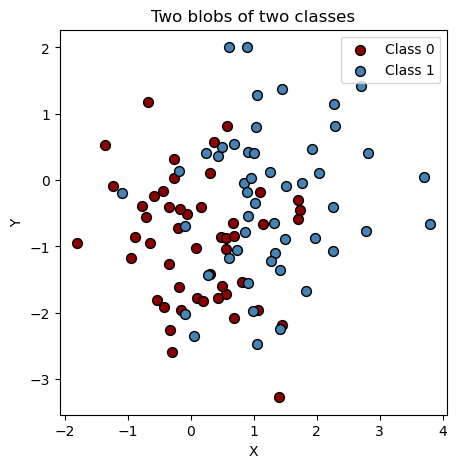

In [239]:
from sklearn.datasets import make_blobs

#visualize two blobs of two classes
X, y = make_blobs(n_samples=100, centers=2, n_features=2, center_box=(-2, 2))

#plot two blobs, label the classes and the axes
plt.figure(figsize=(5,5))
plt.scatter(X[y==0, 0], X[y==0, 1], color='darkred', edgecolor='k', s=50, label="Class 0")
plt.scatter(X[y==1, 0], X[y==1, 1], color='steelblue', edgecolor='k', s=50, label="Class 1")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Two blobs of two classes")
plt.legend()
plt.show()

In [240]:
from sklearn.datasets import make_blobs

# generate blobs with coordinates between -10 and 10
X, y = make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=2)
X = X * 9 / np.max(np.abs(X))

interact(perceptron_visualizer,
         r=FloatSlider(min=0.1, max=10, step=0.1, value=1, description='r'),
         theta=FloatSlider(min=0, max=360, step=1, value=45, description='θ (deg)'),
         b=FloatSlider(min=-10, max=10, step=0.5, value=0, description='b'),
         X=fixed(X),
         y=fixed(y))

interactive(children=(FloatSlider(value=1.0, description='r', max=10.0, min=0.1), FloatSlider(value=45.0, desc…

<function __main__.perceptron_visualizer(r, theta, b, X=None, y=None)>

### Linearity of the perceptron
The perceptron is a linear classifier, which means that it partitions the input space $\mathbb{R}^n$ into two **half-spaces** (these are simply subsets of $\mathbb{R}^n$ lying on either side of a separating hyperplane), and predicts $1$ on one side of the hyperplane and $0$ on the other side. This is being visualized in the above plot.

We can understand this for a fixed $\mathbf{w} \in \mathbb{R}^n$ and $b$ in steps, as follows:
- Start by visualizing the orthogonal subspace to $\mathbf{w}$, i.e. the set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} = 0$. This depends only on the direction of $\mathbf{w}$ and not its magnitude.
- Then, visualize the set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} + b = 0$. This is a hyperplane in $\mathbb{R}^n$, which is obtained by **shifting** the orthogonal subspace by $-b$ along the line $\textup{span}(\mathbf{w})$.
- The set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} > b$ is a half-space (the positive half). This is the set of $\mathbf{x}$ that are "on the same side" of the hyperplane as $\mathbf{w}$.
- The set of $\mathbf{x} \in \mathbb{R}^n$ such that $\mathbf{w}^T\mathbf{x} < b$ is a half-space (the negative half). This is the set of $\mathbf{x}$ that are "on the opposite side" of the hyperplane as $\mathbf{w}$.

Putting it all together, we see that the perceptron is a linear classifier that partitions the input space into two half-spaces, and predicts $1$ for $\mathbf{x}$ lying in the positive half-space, and $0$ for $\mathbf{x}$ lying in the negative half-space.

### The Perceptron Learning Algorithm

The Perceptron Learning Algorithm is a fundamental method for training a simple binary classifier. It is an iterative method that updates the weights of a perceptron based on errors made in classification. Below is a detailed breakdown of how it works.

#### Setup and Notation

We have:
- **Input features**: $\mathbf{x}$, where each sample $\mathbf{x}_i$ has $n$ features.
- **Binary labels**: $y$ ($0$ or $1$).
- **Weights**: $\mathbf{w}$, initialized to zeros or small random values.
- **Bias**: $b$, initialized to zero.
A perceptron makes predictions using a linear decision rule:
$$\hat{y} = H(\mathbf{w} \cdot \mathbf{x} + b),$$
where:
- $\mathbf{w} \cdot \mathbf{x}$ is the dot product of the weight vector and input features.
- $b$ is the bias term (optional but useful).
- $H$ is $1$ if the input is positive, $0$ otherwise.

#### Learning Algorithm

**Step 1: Initialize Weights and Bias**: Set all weights $\mathbf{w}$ to zero, and also $b=0$.

**Step 2: Iterate Over the Dataset**

For each training sample $(\mathbf{x}_i, y_i)$:
- *Make prediction*: $\hat{y}_i = H(\mathbf{w} \cdot \mathbf{x}_i + b).$
- *Update rule*: Update the weights and bias as follows:
\begin{align*}
    \mathbf{w} &\leftarrow \mathbf{w} + \eta (y_i - \hat{y}_i) \mathbf{x}_i,\\
    b &\leftarrow b + \eta (y_i - \hat{y}_i),
\end{align*}
where $\eta$ is the learning rate (a small positive constant, e.g., 0.01). Note: If $y_i = \hat{y}_i$, then the update does nothing! If $y_i \neq \hat{y}_i$, then the update moves the weights and bias in the direction that reduces the error.

**Step 3: Repeat Until Convergence**: Continue updating until all points are correctly classified or a maximum number of iterations is reached.

If the data is linearly separable (i.e. there actually does exist a hyperplane which divides the two classes), then the algorithm is guaranteed to converge to a solution!

We can easily run the Perceptron algorithm using `sklearn`'s `Perceptron` class. Let's see how it works on a simple synthetic dataset.

Weights: [0.03366824 0.00370909]
Bias: 0.01
Final Accuracy: 0.9
Number of steps: 1000


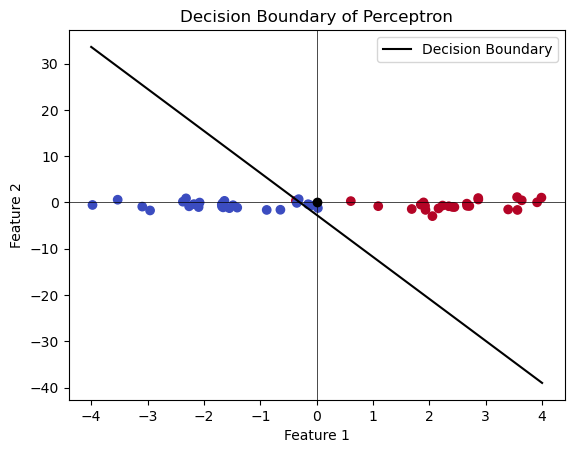

In [236]:
# import libraries for data generation and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import make_blobs

# Create two horizontally separated blobs
X, y = make_blobs(n_samples=50, centers=2, cluster_std=1.0, 
                  center_box=(-3.0, 3.0))
# Move the blobs horizontally apart by adding offset to x coordinates
X[y == 0, 0] -= 1  # Move left blob further left
X[y == 1, 0] += 1  # Move right blob further right

# import precpetron class
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron(max_iter=1000, # Maximum number of iterations
                        eta0=0.01, # Learning rate
                        tol= None, # Tolerance for stopping criteria, i.e. if the change in loss is less than this value, training stops
                        random_state=42, # Random seed for reproducibility
                        early_stopping=False, # Stop once the validation score is not improving
                        # validation_fraction=0.1, # Fraction of training data to set aside as validation set for early stopping
                        # n_iter_no_change=50 # Maximum number of epochs with no improvement on the validation score
                        )
# Fit the model to the dataset
perceptron.fit(X, y)
# Get the weights and bias from the trained model
weights = perceptron.coef_[0]
bias = perceptron.intercept_[0]
# Calculate the slope and intercept of the decision boundary
slope = -weights[0] / weights[1]
intercept = -bias / weights[1]

# Print the weights and bias
print("Weights:", weights)
print("Bias:", bias)
# Print the final accuracy of the model
print("Final Accuracy:", perceptron.score(X, y))
# Print the number of steps (epochs) required for training
print("Number of steps:", perceptron.n_iter_)

#visualize the decision boundary
fig, ax = plt.subplots()
# make axis background white
ax.set_facecolor('white')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
# plot the origin
plt.plot(0, 0, 'ko')
x_vals = np.linspace(-4, 4, 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='black', label='Decision Boundary')
# plot x and y axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.title("Decision Boundary of Perceptron")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### Softening the Perceptron
The perceptron is a simple and elegant algorithm, but it has some limitations. The main limitation is that if the data is not **linearly separable** (i.e. there is no hyperplane separating the two classes perfectly), then the algorithm will not converge to solution (instead, it will continue until the number of iterations is reached, or the accuracy stops improving with further epochs). 

Note also that the perceptron is a hard classifier, since it outputs only $0$ or $1$. 

It is natural then to try to soften the perceptron into a soft classifier: the output should be a float between $0$ and $1$, with larger values indicating higher probability of being in class $1$, and smaller values indicating higher probability of being in class $0$. Quite intuitively/logically, the output should be exactly $0.5$ when the input is on the hyperplane, indicating that the classifier is uncertain about the class of the input along the hyperplane.

In summary, we want to replace the Heaviside function $H$ with a function $\sigma$ that satisfies the following properties (you should note that we will be applying this with $z = \mathbf{w}^T\mathbf{x} + b$):
- $\sigma(z) \in [0,1]$ for all $z \in \mathbb{R}$.
- $\sigma(z) \to 0$ as $z \to -\infty$.
- $\sigma(z) \to 1$ as $z \to \infty$.
- $\sigma(0) = 0.5$.

The function that satisfies these properties is the **logistic function**:
\begin{equation*}
    \sigma(z) = \frac{1}{1 + e^{-z}}.
\end{equation*}
This function is also called the **sigmoid function**. It is a smooth, continuous function that maps any real number to the interval $[0,1]$. It is also differentiable, which makes it useful for optimization algorithms like gradient descent.

### Logistic Regression
The logistic regression model for binary classification is the soft classifier that we get by replacing the Heaviside function in the perceptron with the logistic function. The model is defined as follows:
\begin{equation*}
    P_{\mathbf{w},b}(\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T\mathbf{x} + b)}}.
\end{equation*}
The model is trained by minimizing the **log loss** (also called the **binary cross-entropy loss**), which is a sophisticated measure of the difference between the predicted probabilities and the true labels. The log loss, denoted $\mathcal{L}$, is defined as follows:
\begin{equation*}
    \mathcal{L}(\mathbf{w},b) = - \frac{1}{m} \log \left( \prod_{i=1}^m \hat{y}_i^{y_i} (1 - \hat{y}_i)^{1 - y_i} \right),
\end{equation*}
where as usual $\hat{y}_i = P_{\mathbf{w},b}(\mathbf{x}_i)$, and $m$ is the number of samples in the dataset. 

This looks quite ridiculous and complicated. Using the magical properties of the logarithm, we can simplify this as follows:
\begin{align*}
    \mathcal{L}(\mathbf{w},b) & = - \frac{1}{m} \log \left( \prod_{i=1}^m \hat{y}_i^{y_i} (1 - \hat{y}_i)^{1 - y_i} \right)\\
    & = - \frac{1}{m} \sum_{i=1}^m \log \left( \hat{y}_i^{y_i} (1 - \hat{y}_i)^{1 - y_i} \right)\\
    & = - \frac{1}{m} \sum_{i=1}^m y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i).
\end{align*}
We will see next time that, in fact, this loss function is the negative of the log-likelihood $P(\vec{X} \mid Y)$ of the logistic regression model, which is why it is called the log loss!
